In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [4]:
n = 100
m = 20
d = 3

### Define Dataset

In [5]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)

In [6]:
def create_sample():
    cluster_centers = [-0.8, 0, 0.8]
    choice = np.random.choice(cluster_centers, size=2, replace=True)
    
    y_sample = -1
    if (choice[0] != -choice[1]) and not (choice[0] == 0.8 and choice[1] == 0):
        y_sample = 1    
    
    choice += np.random.normal(loc=0, scale=0.1, size=(2,))
    x_sample = np.concatenate([np.ones((1, )), choice])

    return x_sample.reshape(1, -1), y_sample

In [7]:
# samples = [create_sample() for _ in range(n)]
# x = np.concatenate([sample[0] for sample in samples])
# y = np.array([sample[1] for sample in samples]).reshape(-1,)

### Solve L1

In [8]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [9]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

(array([[ 3.81395491e-03,  8.92512203e-03, -1.71253179e-02],
        [-1.91873225e-04,  8.56675143e-05, -2.13071868e-04],
        [-1.00229326e-04, -6.02196393e-05, -4.58898040e-05],
        [ 4.04969662e-02,  9.48242258e-02, -1.82405927e-01],
        [ 2.10644118e-02,  4.92919210e-02, -9.48558809e-02],
        [ 7.05804446e-03,  1.65105945e-02, -3.17791287e-02],
        [ 1.29573071e-01,  3.03535017e-01, -5.83677817e-01],
        [ 4.90617713e-04, -9.70591434e-04,  1.66573273e-03],
        [-1.29600443e-01, -4.05005936e-01,  6.48010698e-02],
        [ 6.22452290e-02,  1.45852228e-01, -2.80395616e-01],
        [ 9.71278099e-02,  2.27404755e-01, -4.37462853e-01],
        [ 1.63641892e-02, -3.65914429e-02,  6.20015372e-02],
        [-1.64911100e-01, -5.15428495e-01,  8.25205250e-02],
        [ 2.26202372e-01,  5.30423433e-01, -1.01921772e+00],
        [ 3.46044446e-04,  9.93018147e-04, -1.92839184e-03],
        [ 6.20663204e-03,  1.44177546e-02, -2.78006521e-02],
        [ 1.24527271e-04

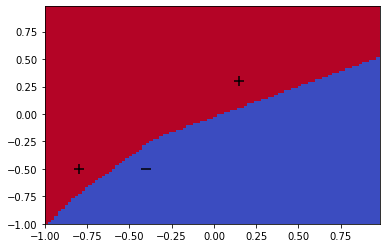

In [10]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [11]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [12]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

0.9999993986005508

### Empirical Gradient Flow

In [13]:
alpha = [10000] * m 
s = [0] * m

w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)
results = train(
    w_0=w_0,
    a_0=a_0,
    x=x,
    y=y,
    m=m,
    d=d,
    alpha=alpha,
    s=s,
    step_size=1e-6,
    n_epochs=10000000,
    eval_freq=1000,
    eval_freq_Q=50000)

 71%|███████   | 7052503/10000000 [15:49<32:19, 1519.79it/s]  

Mu = 0.4323637067872248:: Minimization Failed.


100%|██████████| 10000000/10000000 [27:20<00:00, 6095.58it/s]


##### Plot weights norms over time

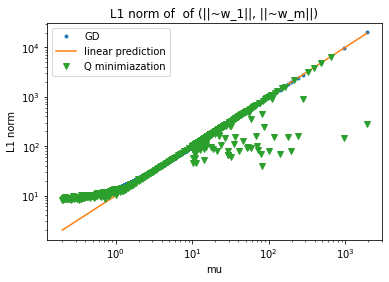

In [14]:
plot([2 * alpha[0]/t for t in results['training_loss']], [np.linalg.norm(r, ord=1) for r in results['w_tilde_norms']], '.')
plot([2 * alpha[0]/t for t in results['training_loss']], [m * alpha[0] / t for t in results['training_loss']])
plot([2 * alpha[0]/t for t in results['training_loss_Q']], [np.linalg.norm(r, ord=1) for r in results['w_tilde_norms_Q']], 'v')

yscale('log')
xscale('log')
ylabel('L1 norm')
xlabel('mu');
title(f'L1 norm of  of (||~w_1||, ||~w_m||)');
legend(['GD', 'linear prediction', 'Q minimiazation']);

##### Plot NTK kerel change over time

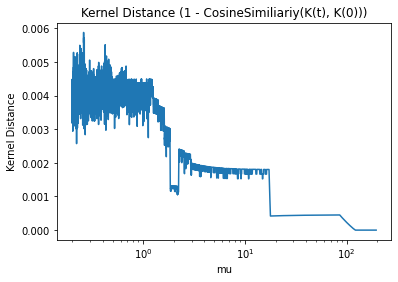

In [15]:
kernel_distances_smooth = pd.Series(results['kernel_distances']).rolling(10).mean()
plot([2 * alpha[0]/t for t in results['training_loss']], kernel_distances_smooth)
#yscale('log')
xscale('log')
ylabel('Kernel Distance')
xlabel('mu');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');

##### Plot decision boundary over time

In [16]:
mu_vals = [2 * alpha[0]/t for t in results['training_loss']]
max(mu_vals), min(mu_vals)

(1915.2607730071425, 0.1990727637020826)

mu = 1915.2607730071425


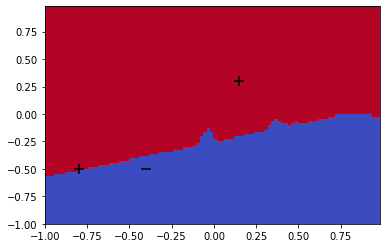

mu = 15.486905271455582


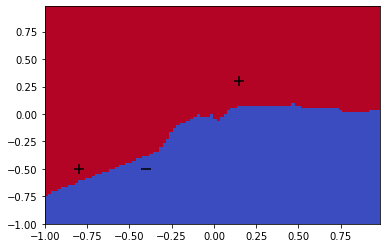

mu = 9.964953480142107


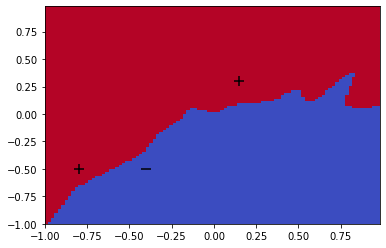

mu = 7.324782739409795


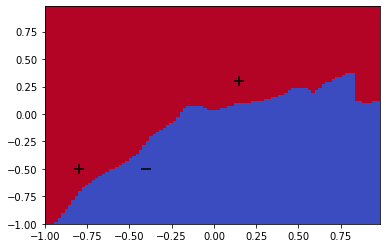

mu = 5.773072369973861


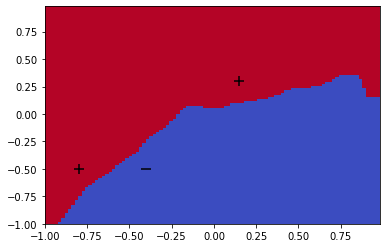

mu = 4.748962136831133


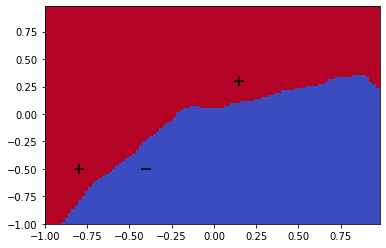

mu = 4.0205466351967365


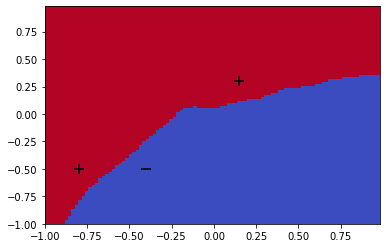

mu = 3.4745548358350047


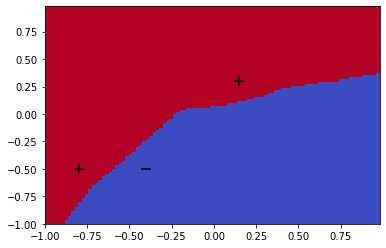

mu = 3.0490993863309552


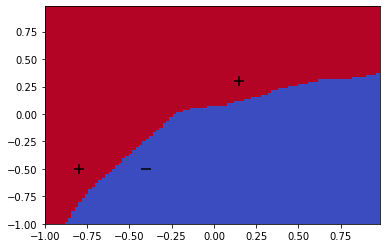

mu = 2.7145914697931155


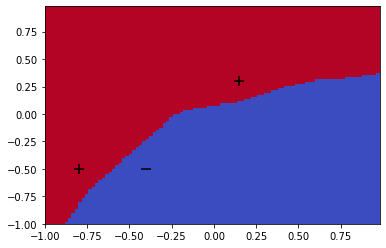

mu = 2.4420272168610624


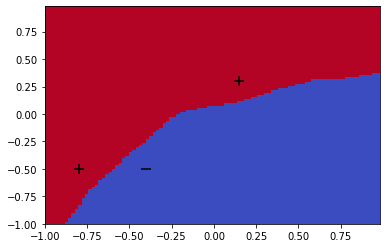

mu = 2.1875755069829577


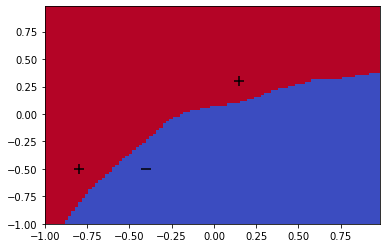

mu = 1.8549508944488187


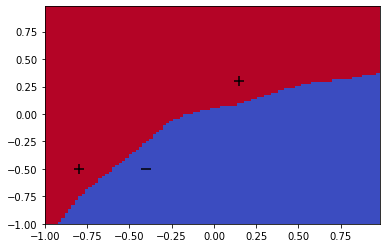

mu = 1.7003512984306612


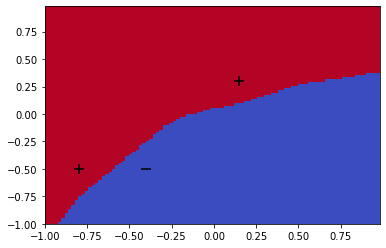

mu = 1.5684565063208513


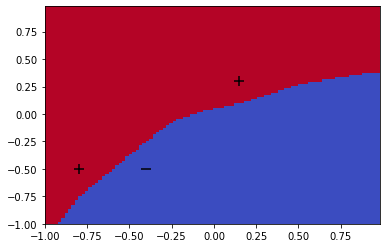

mu = 1.45223560591943


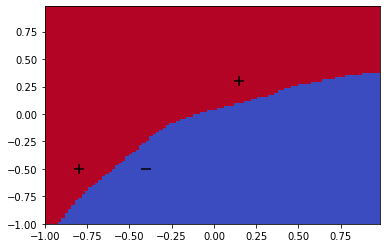

mu = 1.3489126029097935


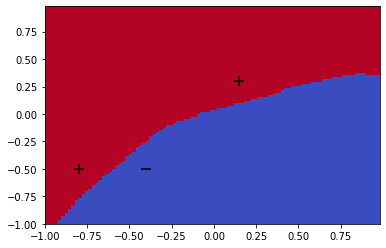

mu = 1.2560940147864468


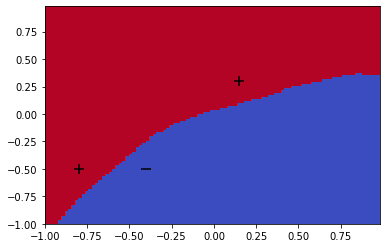

mu = 1.1729883896062692


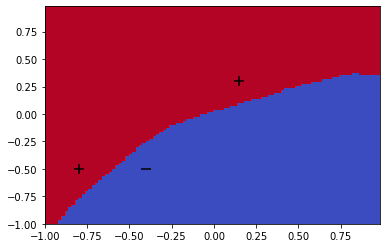

mu = 1.0986311080292313


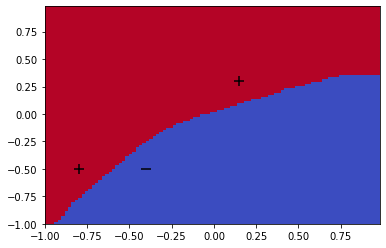

mu = 1.0314938987589812


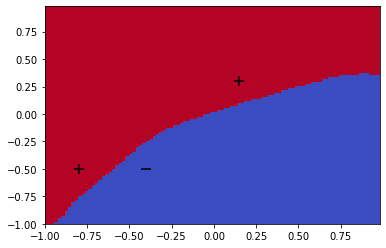

mu = 0.9694858312822238


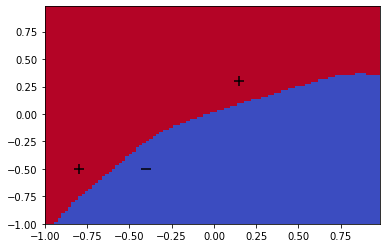

mu = 0.912059050492715


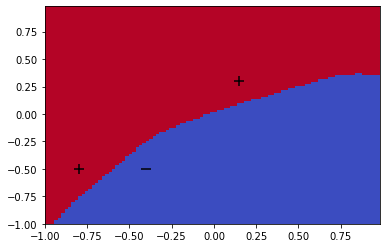

mu = 0.8587454698213728


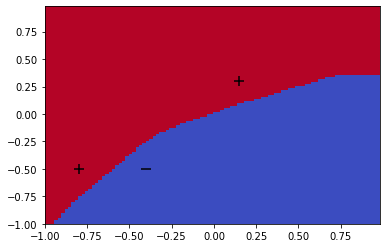

mu = 0.8091429194011509


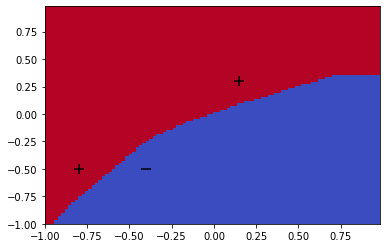

mu = 0.7629031513227842


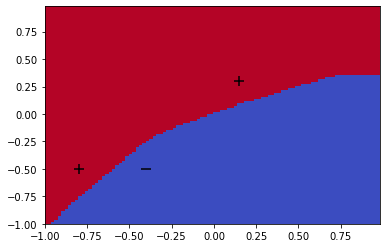

mu = 0.719723041762943


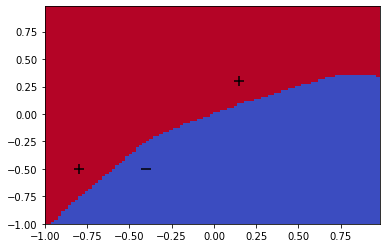

mu = 0.6793933794443062


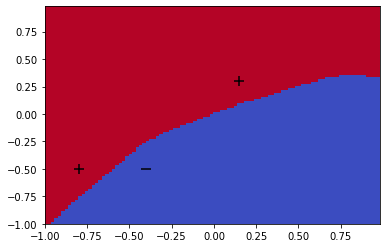

mu = 0.6420222471858678


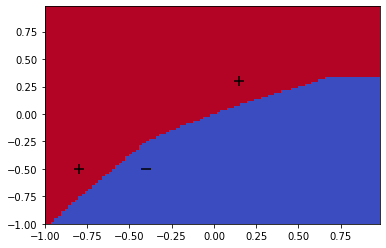

mu = 0.6069129759852288


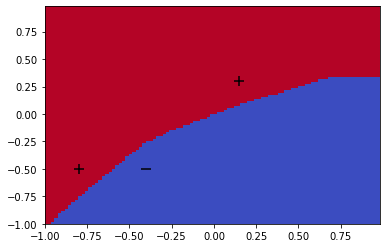

mu = 0.5739569738300584


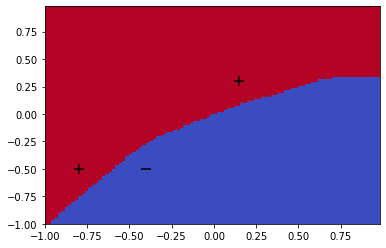

mu = 0.5434228086881525


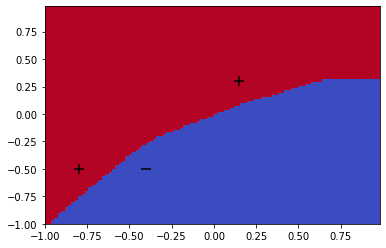

mu = 0.5146215131565565


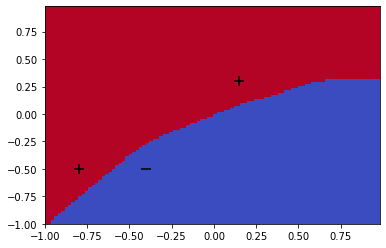

mu = 0.4874855207518765


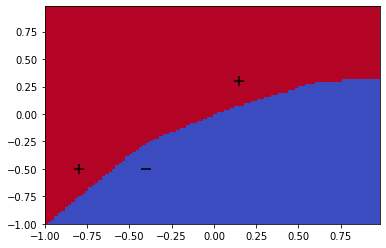

mu = 0.46207507663523395


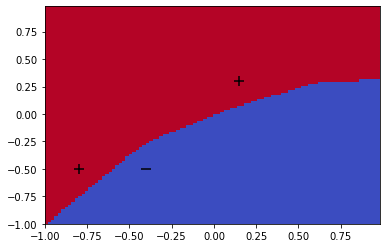

mu = 0.4380487910177758


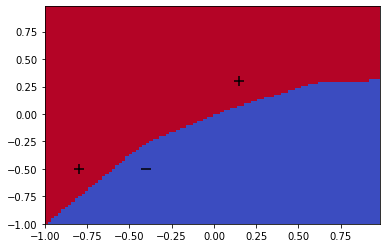

mu = 0.41532243158672627


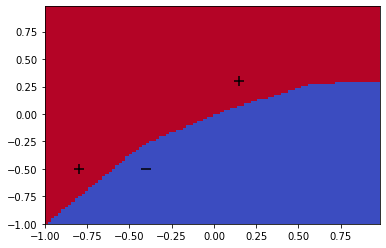

mu = 0.39381802216327516


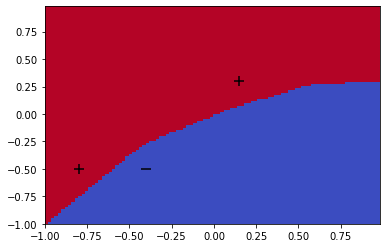

mu = 0.37346345165638717


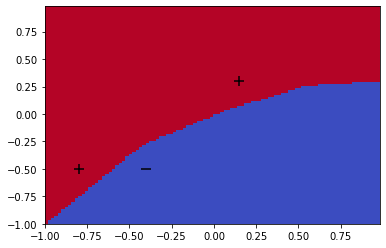

mu = 0.3541917013297031


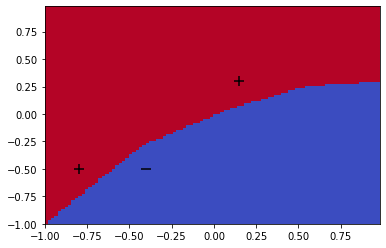

mu = 0.3359405479213192


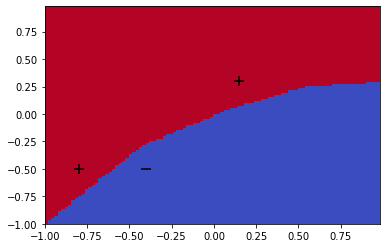

mu = 0.3186519132140121


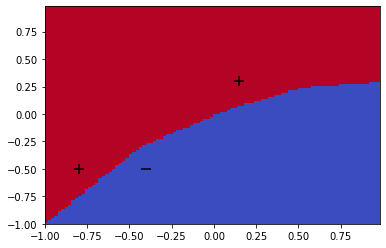

mu = 0.30227165895985864


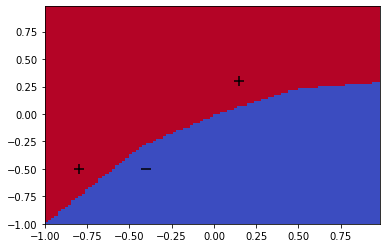

mu = 0.28674918133896693


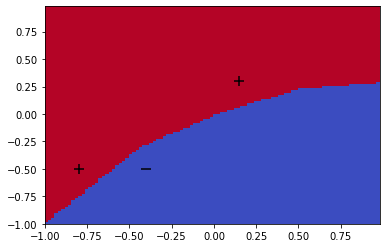

mu = 0.2720370684201743


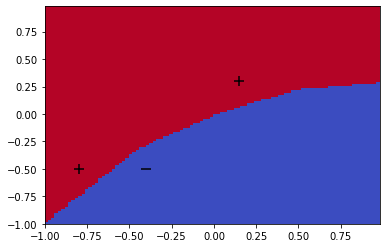

mu = 0.2582008161252433


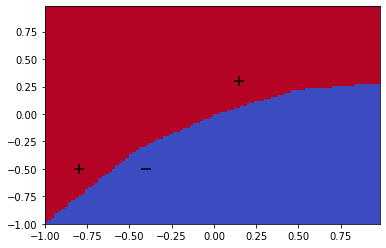

mu = 0.24508247871984692


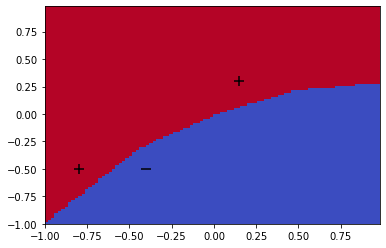

mu = 0.23263679175899285


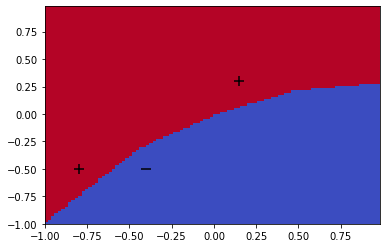

mu = 0.22082818487610656


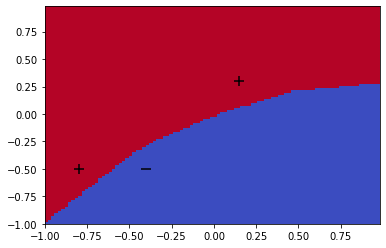

mu = 0.20962311608734593


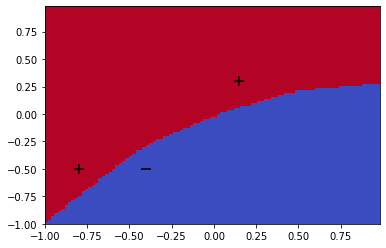

In [17]:
num_plots = 50
idx = 0
for i in range(num_plots):
    print("mu = {}".format(2 * alpha[0]/results['training_loss'][idx]))
    plot_classifier(results['w'][idx], results['a'][idx], x, y)
    idx += len(results['training_loss']) // num_plots    

##### NTK solution

In [18]:
clf = fit_svm_with_tangent_kernel(w_0, a_0, x, y)

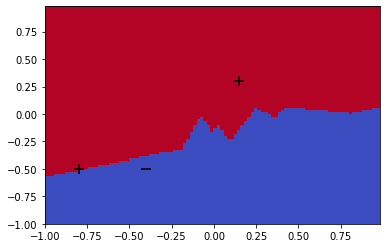

In [19]:
plot_svm_classifier(clf, x, y)

##### Plot excess L1 over time

In [106]:
excesss_L1 = [np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1 
              for w_tilde_norms in results['w_tilde_norms']]

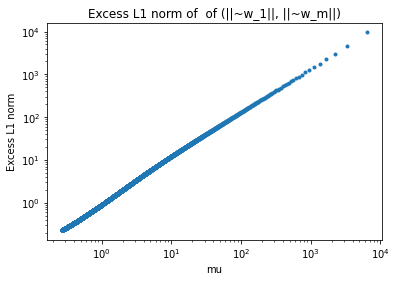

In [107]:
plot([2 * alpha[0]/t for t in results['training_loss']], excesss_L1, '.')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('mu');
title(f'Excess L1 norm of  of (||~w_1||, ||~w_m||)');

### Empirical Gradient Flow- Comparing Different Scales

In [108]:
# TODO

### The Effect of Shape

In [115]:
alpha = [10000] * m
s = [0.95] * (m//2) + [0] * (m//2)

w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=False) # using general non-symmetric init here to allow
                                                                        # each neuron to be independent with its own shape
results = train(
    w_0=w_0,
    a_0=a_0,
    x=x,
    y=y,
    m=m,
    d=d,
    alpha=alpha,
    s=s,
    step_size=1e-6,
    n_epochs=10000000,
    eval_freq=1000,
    eval_freq_Q=np.inf)  # don't eval Q

100%|██████████| 1000000/1000000 [00:52<00:00, 18901.35it/s]


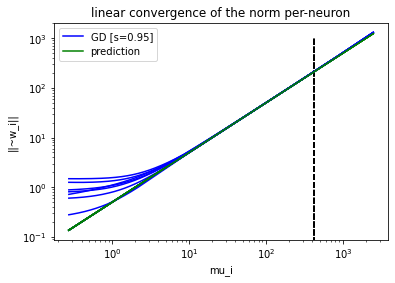

In [28]:
for i in range(m//2):
    marker = 'b'
    plot([2 * alpha[i]/t for t in results['training_loss']], [r[i] for r in results['w_tilde_norms']], marker)
    plot([2 * alpha[i]/t for t in results['training_loss']], [alpha[i] / gamma_tilde for gamma_tilde in results['training_loss']], 'g')

    first_perfect_fit_index = np.where(np.array(results['training_accuracy']) == 1.0)[0][5]
    first_perfect_fit_mu = 2 * alpha[i]/results['training_loss'][first_perfect_fit_index]
    vlines(first_perfect_fit_mu, 0, 1e3, linestyles='dashed', color='k')

yscale('log')
xscale('log')
ylabel('||~w_i||');
xlabel('mu_i');
title(f'linear convergence of the norm per-neuron');
legend(['GD [s=0.95]', 'prediction']);

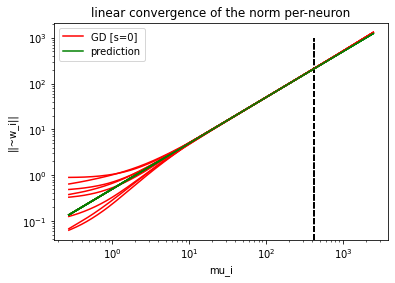

In [29]:
for i in range(m//2, m):
    marker = 'r'
    plot([2 * alpha[i]/t for t in results['training_loss']], [r[i] for r in results['w_tilde_norms']], marker)
    plot([2 * alpha[i]/t for t in results['training_loss']], [alpha[i] / gamma_tilde for gamma_tilde in results['training_loss']], 'g')

    first_perfect_fit_index = np.where(np.array(results['training_accuracy']) == 1.0)[0][5]
    first_perfect_fit_mu = 2 * alpha[i]/results['training_loss'][first_perfect_fit_index]
    vlines(first_perfect_fit_mu, 0, 1e3, linestyles='dashed', color='k')

yscale('log')
xscale('log')
ylabel('||~w_i||');
xlabel('mu_i');
title(f'linear convergence of the norm per-neuron');
legend(['GD [s=0]', 'prediction']);

### Plot q_s

Text(0.5, 1.0, 'q_s')

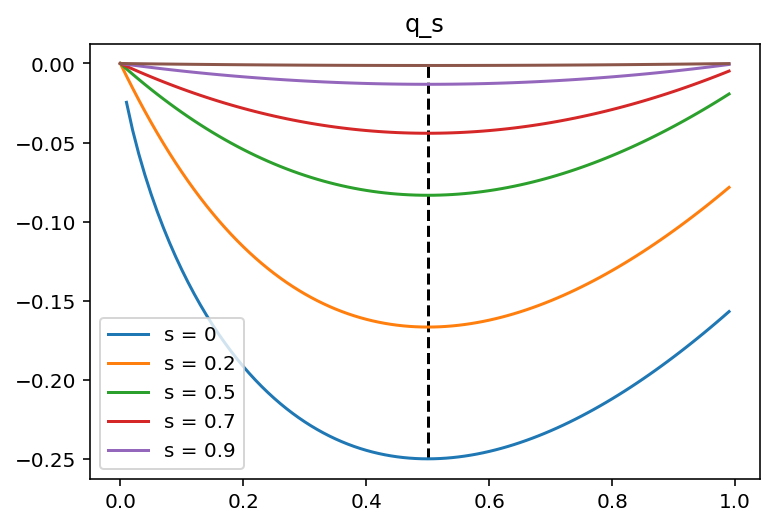

In [60]:
mu = 1
x = list(np.arange(0, mu, 0.01))
for s in [0, 0.2, 0.5, 0.7, 0.9, 0.99]:
    plot(x, list(map(lambda x: q_func(x/mu, s), x)))
    
vlines(0.5, -0.25, 0, linestyles='dashed')
legend([f's = {k}' for k in [0, 0.2, 0.5, 0.7, 0.9]])
title('q_s')